# Shared clonotype frequency

In this notebook, we're going to make the following figure panels:

  * Probability of observed repertoire overlap (lower half of **Figure 3a**)
  * Shared clonotypes in observed and synthetic repertoires (**Figure 3b**)

The following Python packages are required to run the code in this notebook:
  * matplotlib
  * numpy
  * pandas
  * scipy
  * seaborn
  * [abutils](https://github.com/briney/abutils)

They can be install by running `pip install matplotlib numpy pandas scipy seaborn abutils`

*NOTE: this notebook requires the use of the Unix command line tool `wc`. Thus, it requires a Unix-based operating system to run correctly (MacOS and most flavors of Linux should be fine). Running this notebook on Windows 10 may be possible using the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/about) but we have not tested this.*

In [2]:
from __future__ import print_function

from collections import Counter
import itertools
import multiprocessing as mp
import os
import subprocess as sp
import sys

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import hypergeom

from abutils.utils.jobs import monitor_mp_jobs
from abutils.utils.pipeline import list_files, make_dir
from abutils.utils.progbar import progress_bar

%matplotlib inline

### Subjects

In [3]:
with open('../data_processing/data/subjects.txt') as f:
    subjects = f.read().split()

### Probability of observed repertoire overlap

To compute the statistical likelihood of the observed level of repertoire overlap given the total size of the repertoire and the depth at which each sample was sampled, we'll construct a hypergeometric distribution. We can then sum the probabilities for all levels of repertoire overlap equal to or greater than the observed overlap.

In [4]:
def chao2(counts, m):
    m = float(m)
    s_obs = sum([float(c) for c in counts.values()])
    q1 = float(counts['1'])
    q2 = float(counts['2'])
    return s_obs + ((m - 1) / m) * ((q1 * (q1 - 1)) / (2 * (q2 + 1)))


def compute_overlap_probability(s1, s2, div):
    s1_count = 0
    with open('../data_processing/data/cross-subject_clonotype_duplicate-counts/{}_occurrence-counts.txt'.format(s1)) as f:
        for line in f:
            if not line.strip():
                continue
            obs, count = line.split()
            s1_count += int(obs) * int(count)
    s2_count = 0
    with open('../data_processing/data/cross-subject_clonotype_duplicate-counts/{}_occurrence-counts.txt'.format(s2)) as f:
        for line in f:
            if not line.strip():
                continue
            obs, count = line.split()
            s2_count += int(obs) * int(count)
    shared_counts = {}
    with open('../data_processing/data/cross-subject_clonotype_duplicate-counts/{}-{}_occurrence-counts.txt'.format(*sorted([s1, s2]))) as f:
        for line in f:
            if not line.strip():
                continue
            obs, count = line.split()
            shared_counts[obs] = int(count)
    rv = hypergeom(div, max(s1_count, s2_count), min(s1_count, s2_count))
    pmfs = list(rv.pmf(range(shared_counts['2'])))
    prob = 1 - sum(pmfs[:-1])
    return {'probability': prob, 'subject': s1, 'subject2': s2}

First, we need to calculate the total cross-subject diversity (all 10 subjects)

In [5]:
all_shared_counts = {}
with open('../data_processing/data/cross-subject_clonotype_duplicate-counts/{}_occurrence-counts.txt'.format('-'.join(subjects))) as f:
    for line in f:
        if not line.strip():
            continue
        obs, count = line.split()
        all_shared_counts[obs] = int(count)
div = chao2(all_shared_counts, 10)

Next we calculate the probabilty of the observed overlap between each pair of subjects, and convert the probabilities to a DataFrame

In [6]:
probs = []
for i, s1 in enumerate(subjects):
    for s2 in subjects[i + 1:]:
        probs.append(compute_overlap_probability(s1, s2, div))

prob_df = pd.DataFrame(probs)

Finally, we plot the probabilities on a horizontal scatterplot. If you'd like to save the figure rather than just showing inline, comment out the `plt.show()` line and uncomment the last line (beginning with `plt.savefig`) and alter the figure path if desired.

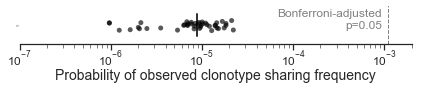

In [71]:
sns.set_style('white')
plt.figure(figsize=(6, 1.35))

# plot the data
sns.stripplot(x=prob_df['probability'], y=['2-subject\nsharing'] * len(prob_df['probability']), jitter=0.15, alpha=0.65, color='k')

# draw a vertical line at the mean
plt.axvline(x=prob_df['probability'].mean(), ymin=0.2, ymax=0.8, linewidth=2, color='k', alpha=0.8)

# plot the Bonferroni-corrected value for p=0.05
corrected_pval = 0.05 / 45
plt.axvline(x=corrected_pval, ymin=0, ymax=5, linewidth=1, color='gray', linestyle='dashed')
plt.text(corrected_pval - 0.15 * corrected_pval, 0.075, 'Bonferroni-adjusted\np=0.05', ha='right', color='gray', fontsize=12)

# style the plot
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlim(10**-7, 2 * 10**-3)
ax.tick_params(axis='x', which='minor', bottom='on', top='off', direction='out', length=4)
ax.tick_params(axis='x', which='major', bottom='on', top='off', direction='out', labelsize=12,
               length=6, pad=-3, width=1.25)
ax.tick_params(axis='y', which='major', labelsize=0, length=0, width=1.25, pad=0, right=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel('', size=0, labelpad=0)
plt.xlabel('Probability of observed clonotype sharing frequency', size=14, labelpad=0)

# save or show
plt.tight_layout()
plt.show()
# plt.savefig('./random-sharing-probability_horiz-scatterplot.pdf', transparent=True)

### Total clonotype counts

In [7]:
def get_clonotype_counts(sample_size_file):
    sample_sizes = {}
    with open(sample_size_file) as f:
        for line in f:
            if line.strip():
                sample, size = line.strip().split()
                sample_sizes[sample] = int(size)
    return sample_sizes

In [8]:
sample_sizes = get_clonotype_counts('../data_processing/data/shared_clonotypes/subject_sizes.txt')
sample_sizes_synthetic_default = get_clonotype_counts('../data_processing/data/shared_clonotypes/subject_sizes_synthetic_default-model.txt')
sample_sizes_synthetic_subject_specific = get_clonotype_counts('../data_processing/data/shared_clonotypes/subject_sizes_synthetic_subject-specific-models.txt')

### Shared clonotype frequencies

In [9]:
def get_frequencies(shared_files, sample_sizes):
    frequencies = []
    for of in shared_files:
        subjects = os.path.basename(of).split('_')[0].split('-')
        if len(subjects) == 1:
            continue
        smallest = min([v for k, v in sample_sizes.items() if k in subjects])
        min_freq = str(len(subjects))
        with open(of) as f:
            for line in f:
                if not line.strip():
                    continue
                if line.strip().split()[0] == min_freq:
                    count = int(line.strip().split()[1])
                    break
        freq = 1. * count / smallest
        frequencies.append({'Clonotype overlap (subjects)': int(min_freq), 'Frequency (%)': freq})
    freq_df = pd.DataFrame(frequencies)
    return freq_df

In [10]:
freq_df = get_frequencies(list_files('../data_processing/data/cross-subject_clonotype_duplicate-counts/'),
                          sample_sizes)

dsynth_freq_df = get_frequencies(list_files('../data_processing/data/cross-subject_synthetic_default-model_duplicate-counts/'),
                                 sample_sizes_synthetic_default)

ssynth_freq_df = get_frequencies(list_files('../data_processing/data/cross-subject_synthetic_subject-specific-models_duplicate-counts/'),
                                 sample_sizes_synthetic_subject_specific)

If you'd like to save the figure rather than just showing inline, comment out the `plt.show()` line and uncomment the last line (beginning with `plt.savefig`) and alter the figure path if desired.

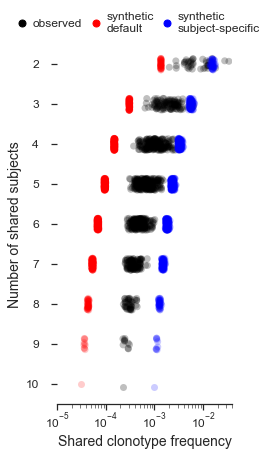

In [16]:
sns.set_style('white')
plt.figure(figsize=(3.5, 6))

sns.stripplot(data=freq_df, x='Frequency (%)', y='Clonotype overlap (subjects)',
              orient='h', color='k',
              jitter=0.15, size=7, alpha=0.25)

sns.stripplot(data=dsynth_freq_df, x='Frequency (%)', y='Clonotype overlap (subjects)',
              orient='h', color='r',
              jitter=0.15, size=7, alpha=0.2)

sns.stripplot(data=ssynth_freq_df, x='Frequency (%)', y='Clonotype overlap (subjects)',
              orient='h', color='b',
              jitter=0.15, size=7, alpha=0.2)

# axis labels
plt.xlabel('Shared clonotype frequency', size=14, labelpad=4)
plt.ylabel('Number of shared subjects', size=14, labelpad=4)

# layout parameters
ax = plt.gca()
ax.set_xlim([0.00001, .04])
ax.set_xscale('log')
ax.tick_params(axis='x', which='minor', bottom='on', top='off', direction='out', length=4)
ax.tick_params(axis='x', which='major', bottom='on', top='off', direction='out', labelsize=12,
               length=6, pad=0, width=1.25)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot the legend
lobs = plt.Line2D([], [], color='k', marker='o', linestyle='', markersize=7, label='observed')
ldsynth = plt.Line2D([], [], color='r', marker='o', linestyle='', markersize=7, label='synthetic\ndefault')
lssynth = plt.Line2D([], [], color='b', marker='o', linestyle='', markersize=7, label='synthetic\nsubject-specific')
legend = plt.legend(handles=[lobs, ldsynth, lssynth], loc='lower center',
                    columnspacing=0.25, handletextpad=0, handlelength=1.75, fontsize=12,
                    bbox_to_anchor=(0.45, 1.0), ncol=3)

# save or show
plt.tight_layout()
plt.show()
# plt.savefig('./figures/cross-subject_repertoire_overlap.pdf', additional_artists=[legend], bbox_inches='tight')